# TS9: Filtrado No Lineal

**Materia:** Análisis y Procesamiento de Señales  
**Carrera:** Ingeniería Electrónica – UNSAM  
**Docente:** Mariano Llamedo Soria, Francisco Hernan Ledesma y David Ezequiel Benoit  
**Integrantes:** Naudeau Nahiara y Gil María Serena  
**Fecha:** 23/11/2025  

---

## Objetivo

Nuestro objetivo en este trabajo es mitigar las interferencias de movimiento de línea de base $b[n]$ en una señal de electro cardiograma (ECG) mediante la implementación y el análisis comparativo de dos técnicas de estimación: el filtro de mediana y la interpolación por splines cúbicos sobre puntos isoelectricos. Además, se busca aplicar el concepto de filtro adaptado (matched filter) para diseñar un detector de latidos, y cuantificar su rendimiento utilizando métricas estadísticas para evaluar la precisión de las detecciones obtenidas.

---

## Introducción

El electrocardiograma (ECG) es una herramienta diagnóstica fundamental en cardiología, registrando la actividad eléctrica del corazón. Sin embargo, esta señal es suceptible a diversas interferencias que pueden enmascarar las características clínicas relevantes. Una de las interferencias más comunes y problemáticas es el movimiento de línea de base $b[n]$, que consiste en oscilaciones de muy baja frecuencia y alta energía, generadas principalmente por la respiración o el movimiento del paciente. Esta interferencia dificulta el análisis preciso de la morfología del complejo QRS y la estimación de los segmentos isoelectricos.

Se utilizaran 3 técnicas e filtrado:


- Filtro de Mediana: Esta es una técnica de filtrado no lineal que preserva los bordes (como el complejo QRS de alta pendiente) mientras suaviza las variaciones lentas. Se basa en reemplazar cada muestra por el valor de la mediana dentro de una ventana de tiempo definida. En el contexto de la línea de base, se aplica sobre ventanas grandes para estimar la componente de baja frecuencia sin ser afectada significativamente por los picos rápidos del QRS.

- Interpolación mediante Splines Cúbicos: Es un método que aprovecha la estructura de la señal ECG. Consiste en identificar puntos en la señal donde la actividad cardiaca es nula (eléctricamente silente), como el segmento PQ o TP (puntos isoelectricos). Una vez localizados estos puntos, se utiliza un spline cúbico (una función polinomial a tramos de tercer orden) para interpolarlos y generar una estimación suave y continua de la línea de base ($\mathbf{\hat{b}}$) entre ellos.

- Filtro Adaptado (Matched Filter): Se utiliza para la detección de latidos. Es un filtro lineal diseñado para maximizar la relación señal-ruido (SNR) de una señal conocida (el patrón QRS, en este caso) dentro de un fondo de ruido aleatorio. Su salida es la convolución de la señal de entrada con una versión invertida en el tiempo del patrón QRS, produciendo un pico de alta amplitud y forma predecible en el momento exacto en que el patrón QRS está presente.



---

## Ejercicios y Resoluciones

Se estima $\mathbf{\hat{b}}$ a partir de la siguiente expresión:
$$\mathbf{\hat{b}} = \underset{600}{\text{med}} \left( \underset{200}{\text{med}}(\mathbf{s}) \right)$$
siendo $\underset{t}{\text{med}}(\mathbf{s})$ el operador de mediana de $t$ milisegundos que se aplica sobre la señal $\mathbf{s}$, es decir:$$\mathbf{\hat{b}} = \text{med}(\mathbf{m}[n], \mathbf{m}[n-1], \ldots, \mathbf{m}[n - 600 \cdot f_s])$$donde$$\mathbf{m}[n] = \text{med}(\mathbf{s}[n], \mathbf{s}[n-1], \ldots, \mathbf{s}[n - 200 \cdot f_s])$$

(3000.0, 5000.0)

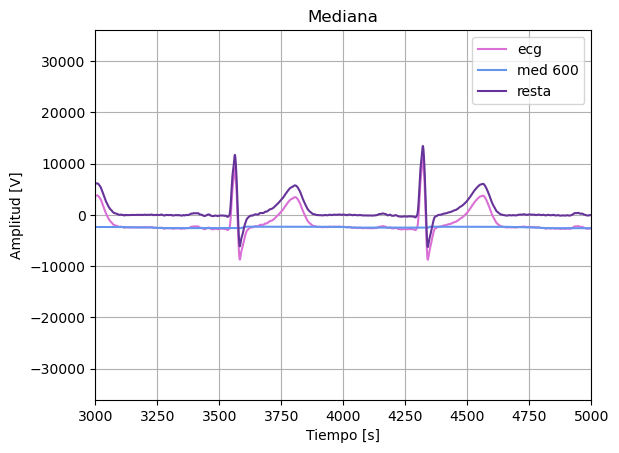

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import interpolate
from scipy.signal import find_peaks

#ECG
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)
cant_muestras = N



#--------(1) Filtro de mediana--------#

fs = 1000
k200 = int(0.2 * fs) | 1   #cantidad de muestras de la mediana
k600 = int(0.6 * fs) | 1
#esta codeado de esta forma porque necesitaba asegurar que mi fs sea 1000Hz y que quede impar tmb

ECG_med200 = signal.medfilt(ecg_one_lead, k200) #kernel size impar porque algo par no tiene media
#200 es la canti

ECG_med600 = signal.medfilt(ECG_med200, k600) #kernel size impar porque algo par no tiene media

resta = ecg_one_lead-ECG_med600

plt.figure(1)
plt.plot(ecg_one_lead, label = 'ecg', color = 'orchid')
plt.plot(ECG_med600, label = 'med 600', color = 'cornflowerblue')
plt.plot(resta, label = 'resta', color = 'rebeccapurple')
plt.title('Mediana')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [V]") 
plt.legend()
plt.grid(True)
plt.xlim(3000, 5000)

---

**Análisis de resultados – Punto 1**

El método implementado utiliza una cascada de dos filtros de mediana no lineales (ventanas de 200 ms y 600 ms) para estimar la componente de movimiento de línea de base ($\mathbf{\hat{b}}$)


A diferencia de los filtros lineales (como un pasa-bajos), el filtro de mediana es notablemente efectivo para suavizar la señal de baja frecuencia mientras preserva la forma y amplitud de los transitorios rápidos, como el complejo QRS. 
La primera parte ($\text{med}_{200}$) sirve para remover o atenuar el impacto de los picos QRS y T en la señal de baja frecuencia, produciendo una señal $\mathbf{m}[n]$ que está más cerca de la línea de base, y la segunda parte ($\text{med}_{600}$) actúa como un suavizador adicional sobre $\mathbf{m}[n]$, asegurando que solo las variaciones más lentas (el verdadero movimiento de base) permanezcan en la estimación final $\mathbf{\hat{b}}$.


En el gráfico se puede observar que la señal ECG original presenta un desplazamiento respecto del cero, pero, al sustraerle la línea de base estimada con el filtro de mediana, se obtiene una señal corregida (en violeta) que se encuentra centrada en cero. Además, se preserva la morfología de los complejos QRS y de las ondas T, lo que indica que el procedimiento no distorsiona las características relevantes de la señal.

---


### Punto 2 –  Interpolación mediante splines cúbicos 


A partir de las detecciones provistas en ecg.mat (campo qrs_detections), se puede estimar el nivel isoeléctrico, es decir el momento donde la actividad eléctrica cardíaca es aproximadamente nula. El intervalo entre la onda P y Q, es el momento más adecuado para estimar las características de la interferencia que originan el movimiento de la línea de base. En ese momento el impulso cardíaco es demorado al atravesar el nódulo aurículo-ventricular.

Para la localización del segmento PQ, puede valerse de la localización de cada latido (líneas rojas verticales $\mathbf{n}_k$) y a partir de la misma, anticipar un tiempo adecuado ($\mathbf{n}_{\text{PQ}}$) de manera tal de no incluir la onda P ni Q. Esto resultará en un conjunto valores$$S = \{(\mathbf{m}_k, \mathbf{s}(\mathbf{m}_k)) | k = 1, 2, \ldots, Q\}$$donde $\mathbf{m}_k = \mathbf{n}_k - \mathbf{n}_{\text{PQ}}$ y $Q$ es la cantidad de latidos en el registro ($1903$).Recuerde que la señal de línea de base debe estar remuestreada a la misma frecuencia que el ECG, por lo que debería remuestrear dicha señal (se puede usar la función de interpolación spline para ello).$$\mathbf{\hat{b}}[n] = \text{spline}_3(S, n) | n = 1, 2, \ldots, N$$donde la función $\text{spline}_3$ será la responsable de realizar la interpolación para las $N$ muestras de la señal $\mathbf{s}$.


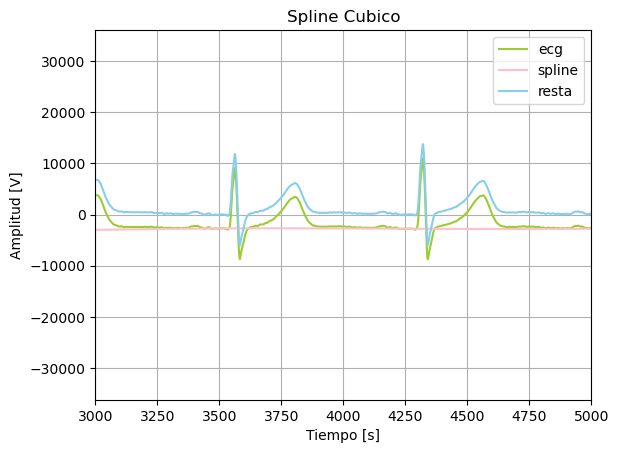

In [2]:
 #--------(2) Interpolación mediante splines cúbicos--------#

fs = 1000
qrs_detections = mat_struct['qrs_detections'].flatten()
n0 = int(0.06 * fs) #numero random de ms antes del QRS
m_i = qrs_detections - n0 #posiciones en el tiempo
m_i = m_i[m_i > 0]  #elimino los negativos para no tomar indices desde el final del vector

#valores de ECG en esos puntos
s_m = ecg_one_lead[m_i] #valores del ecg en las posiciones m_i

Cspline = interpolate.CubicSpline(m_i, s_m) #crea la función spline que interpola entre los puntos PQ
b = Cspline(np.arange(N)) #evalua la spline en todos los puntos del ECG

restaCS = ecg_one_lead-b

plt.figure(2)
plt.plot(ecg_one_lead, label = 'ecg', color = 'yellowgreen')
plt.plot(b, label='spline', color='pink')
plt.plot(restaCS, label = 'resta', color = 'skyblue')
plt.title('Spline Cubico')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [V]") 
plt.legend()
plt.xlim(3000, 5000)
plt.grid(True)
plt.show()

---
**Análisis de resultados – Punto 2**

A diferencia del filtro de mediana que usa una ventana temporal fija, este método usa puntos de anclaje espaciados irregularmente. La clave está en la selección de $\mathbf{m}_k$, que se calcula como una anticipación fija ($\mathbf{n}_{PQ} = 60\ \text{ms}$) respecto a la detección QRS ($\mathbf{qrs\_detections}$). Este punto se ubica en el segmento PQ, un momento en el ciclo cardíaco donde el impulso se demora en el nodo aurículo-ventricular, y la actividad eléctrica es, idealmente, cero.
Una vez que se tienen los puntos de anclaje ($S = \{\mathbf{m}_k, \mathbf{s}(\mathbf{m}_k)\}$), la función CubicSpline crea una función suave de tercer grado que pasa exactamente por todos estos puntos. Esta función continua, evaluada en cada muestra del registro ($\mathbf{b} = \text{spline}_3(n)$), se convierte en la estimación de la línea de base.


La estimación del spline es un poco más suave y menos ruidosa que la obtenida con el filtro de mediana, ya que conecta puntos específicos con una curva analítica.
Al igual que con la mediana, podemos observar en el gráfico como la línea de base sustraída a la señal original, ayuda a centrar en 0 la señal.


Este método ofrece una estimación de la línea de base de mayor precisión morfológica en comparación con el filtro de mediana, especialmente en la región de la onda T, ya que la estimación se basa en la fisiología del ECG (puntos isoeléctricos).

---


### Punto 3 – Simulación y validación numérica (NumPy)

Aplique el concepto de filtro adaptado para diseñar un detector de latidos. Utilice el patrón provisto en el campo qrs_pattern1.


**a)** Explique conceptualmente cómo podría realizar un detector de latidos con la señal resultante del filtro adaptado. Discuta la utilidad y limitaciones de este método.

**b)** Realice la detección de los latidos, comparando las detecciones obtenidas con las que se incluyen en la variable qrs_detections. Proponga alguna métrica (sensibilidad, valor predictivo positivo) para cuantificar la performance del detector.


**Punto 3 - a)**

Un detector de latidos puede basarse en la identificación de picos altos (complejos QRS) mediante técnicas como umbral dinámico, derivadas temporales o correlación con un patrón promedio. El filtro adaptable mejora la relación señal-ruido y permite que estos métodos operen con mayor precisión, reduciendo falsos positivos y negativos.


Sin embargo, su utilidad depende de la calidad del filtrado, si el filtro elimina componentes relevantes o distorsiona la morfología de los latidos, puede comprometer la detección. Además, la variabilidad y la presencia de arritmias pueden requerir ajustes adicionales en el detector, como adaptación de umbrales o validación morfológica.

---

**Punto 3 - b)**

Para realizar la detección de latidos, se aplicó un filtro adaptado (matched filter) sobre la señal ECG previamente corregida mediante spline cúbico. Este filtro consiste en una correlación cruzada entre la señal y un patrón promedio de QRS, previamente normalizado. La salida del filtro resalta las coincidencias morfológicas, permitiendo detectar los latidos como picos por encima de un umbral fijo. Las detecciones obtenidas se compararon con las anotaciones reales (qrs_detections) utilizando una tolerancia temporal, y se evalua la performance mediante métricas objetivas: sensibilidad, precisión y F1-score, construidas a partir de la matriz de confusión.

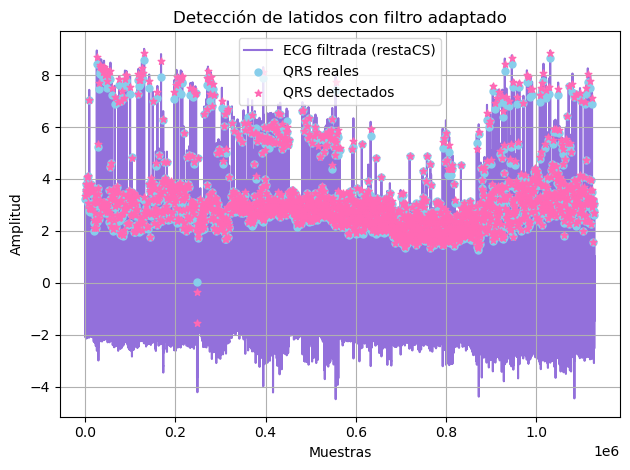

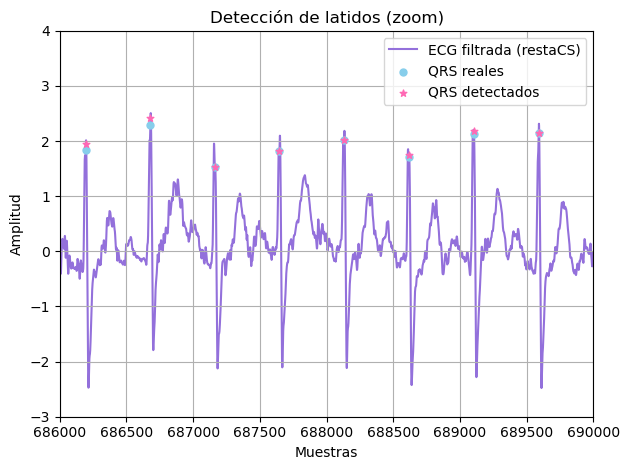

== MATRIZ DE CONFUSIÓN ==
                Predicho
               Sí      No
Real Sí     [1902      1]
Real No     [  2      - ]

== MÉTRICAS ==
Precisión:     0.999
Sensibilidad:  0.999
F1 Score:      0.999


In [7]:
#--------(3)  Filtro adaptado (matched filter)--------#



#----------------cosntruyo mi filtro adaptado----------------#
qrs_real = mat_struct['qrs_detections'].flatten().astype(int)
patron = mat_struct['qrs_pattern1'].flatten().astype(float)
# Se invierte el patrón para hacer correlación

#patron escalado y con valor medio 0
patron = patron - np.mean(patron)
patron = patron / np.std(patron)
valor_medio_patron = np.mean(patron)#verificoo


#normalizo
restaCS = restaCS - np.mean(restaCS)
restaCS = restaCS / np.std(restaCS)


#----------------aplico mi filtro adaptado----------------#
ecg_detection = signal.lfilter(b=patron[::-1], a=1, x=restaCS)
#en vez de usar ecg_one_lead, uso restaCS para la correlacion, esto elimina la línea base y mejora la coincidencia con el patrón

#El filtro adaptado es una correlación cruzada (una convolución con el patrón invertido)


#valor absol
ecg_detection_abs = np.abs(ecg_detection)
ecg_detection_abs = ecg_detection_abs / np.std(ecg_detection_abs)


#compenso mi demora
demora = len(patron) - np.argmax(patron)
ecg_detection_abs = np.roll(ecg_detection_abs, -demora)


#----------------deteccion de picos----------------#

umbral = 1

peaks, _ = signal.find_peaks(ecg_detection_abs, height=umbral, distance=300)

mis_qrs = peaks #mis detecciones


#----------------grafico----------------#

plt.figure(3)
plt.plot(restaCS, label="ECG filtrada (restaCS)", color='mediumpurple', zorder=1)
plt.scatter(qrs_real, restaCS[qrs_real], color='skyblue', label='QRS reales', s=25, zorder=2)
plt.scatter(mis_qrs, restaCS[mis_qrs], color='hotpink', label='QRS detectados',marker='*',s=25, zorder=3)
plt.title("Detección de latidos con filtro adaptado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#zoom
plt.figure(4)
plt.plot(restaCS, label="ECG filtrada (restaCS)", color='mediumpurple', zorder=1)
plt.scatter(qrs_real, restaCS[qrs_real], color='skyblue', label='QRS reales', s=25, zorder=2)
plt.scatter(mis_qrs, restaCS[mis_qrs], color='hotpink', label='QRS detectados',marker='*',s=25, zorder=3)
plt.title("Detección de latidos (zoom)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.xlim(686000, 690000)
plt.ylim(-3, 4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#----------------matriz de confusion----------------#

tol = int(0.05 * fs)   # tolerancia de 50 ms

TP = 0
FP = 0
FN = 0

qrs_real = np.array(qrs_real)
real_marcados = np.zeros(len(qrs_real), dtype=bool)

for p in mis_qrs:
    # buscar un QRS real cercano
    diffs = np.abs(qrs_real - p)
    idx = np.where(diffs < tol)[0]
    if len(idx) > 0:
        TP += 1
        real_marcados[idx[0]] = True
    else:
        FP += 1

FN = np.sum(~real_marcados)


#----------------metricas del detector----------------#

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
sensibilidad = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * sensibilidad / (precision + sensibilidad) if (precision + sensibilidad) > 0 else 0
    
    
#----------------impresion de resultados----------------#

print("== MATRIZ DE CONFUSIÓN ==")
print("                Predicho")
print("               Sí      No")
print(f"Real Sí     [{TP:3d}    {FN:3d}]")
print(f"Real No     [{FP:3d}      - ]")

print("\n== MÉTRICAS ==")
print(f"Precisión:     {precision:.3f}")
print(f"Sensibilidad:  {sensibilidad:.3f}")
print(f"F1 Score:      {f1:.3f}")



---
**Análisis de resultados – Punto 3**

El gráfico completo de la señal muestra la ECG filtrada (línea lila) y la superposición de los QRS reales (círculos celestes) con los QRS detectados (estrellas rosas).

Se observa un patrón de detecciones un tanto inconsistentes en los extremos del registro (al inicio y al final) y en zonas específicas del centro (ej., alrededor de $200,000$ y $400,000$ muestras). En estas áreas, las detecciones superan en número a los QRS reales, indicando una alta tasa de Falsos Positivos (FP). Estas fallas se deben probablemente a ruido residual o cambios bruscos en la morfología del QRS en esas secciones, lo que provoca que la salida del filtro adaptado tenga picos altos, superando el umbral de detección, pero sin corresponder a un latido real.


El zoom sobre una sección más limpia (Muestras $686,000$ a $690,000$) muesta que la mayoría de los QRS reales  son correctamente identificados por los QRS detectados. La ubicación temporal de las detecciones es altamente precisa, lo que confirma la utilidad del filtro adaptado para la localización exacta del pico R. 


Se aprecia un caso donde un QRS real no tiene una estrella rosa asociada, mientras que una estrella rosa no coincide con un QRS real, lo cual se corresponde con los resultados de la matriz de confusión. Respecto a dicha matriz:

- Verdaderos Positivos (TP = 1902): El detector identificó correctamente 1902 de los 1903 latidos reales, lo que demuestra la robustez del método en la mayoría del registro.
- Falso Negativo (FN = 1): Solo un latido real fue omitido (no detectado), probablemente debido a que su morfología se desvió tanto del patrón de referencia que el pico de correlación no superó el umbral.
- Falsos Positivos (FP = 2): Solo se registraron 2 detecciones erróneas.

Además, el corrimiento vertical entre los QRS reales y detectados es un artefacto de la visualización de las métricas sobre la señal original y no un indicador de que la detección sea incorrecta

## Conclusión final

El análisis demostró que el Filtro de Mediana Doble es un método robusto y eficiente para el pre-procesamiento, pero la técnica de Interpolación mediante Splines Cúbicos sobre puntos isoeléctricos resultó ser superior, produciendo una señal corregida (restaCS) con una morfología más limpia y menos artefactos en la onda T, aunque requiere de una detección QRS previa para funcionar. Por su alta calidad, la señal restaCS fue utilizada como entrada para la etapa de detección.


El detector basado en el Filtro Adaptado logro ser una solución óptima para la detección de patrones conocidos, alcanzando un rendimiento muy bueno con un F1 Score de $0.999$. Este resultado demuestra que la estrategia más efectiva es la combinación de métodos como una pre-filtración de alta precisión (Splines) para eliminar el ruido de baja frecuencia, seguida de la optimización de la SNR del filtro adaptado para una localización temporal del latido exacta.
